# Census tract correlation calculations
This notebook contains the code to produce the correlation values and significance values.

In [4]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit
from scipy.special import beta
from scipy.stats import pearsonr, norm
from scipy.stats import t as student_t
from scipy.spatial import distance_matrix

import geopandas as gpd

# 2021
res = gpd.read_file('../preprocessed_data/durham_july_2021/durham_july_2021_census_tract.shp')

# 2022
# res = gpd.read_file('../preprocessed_data/durham_july_2022/durham_july_2022_census_tract.shp')

# 2023
# res = gpd.read_file('../preprocessed_data/durham_july_2023/durham_july_2023_census_tract.shp')

In [5]:
res = res.set_crs(epsg=4269)
# Convert EPSG to 4326 for meters
res = res.to_crs(epsg=3857)
# Remove the n/a rows
mask = ~res['no_unobs'].isna()
res = res[mask]

In [7]:
# Calculate center point of each census tract
res['center'] = res['geometry'].centroid
x, y = res['center'].x.values, res['center'].y.values
coords = np.vstack([x, y]).T

dist = distance_matrix(coords, coords)

[4.47814246e-01 1.39043808e-04]
[5.26452090e-01 4.99005059e-04]
[6.82481891e-01 5.41456146e-04]
[26, 126, 164, 186, 222, 228, 260, 288, 224]
[0.22672775 0.00062284]
[0.11862209 0.07349885 0.02980178 0.02674496 0.         0.
 0.         0.         0.        ]
[26, 126, 164, 186, 222, 228, 260, 288, 224]
[0.09635747 0.00033654]
[0.06936551 0.05185539 0.0289851  0.0266991  0.01163009 0.02397002
 0.00334402 0.00416001 0.01366061]


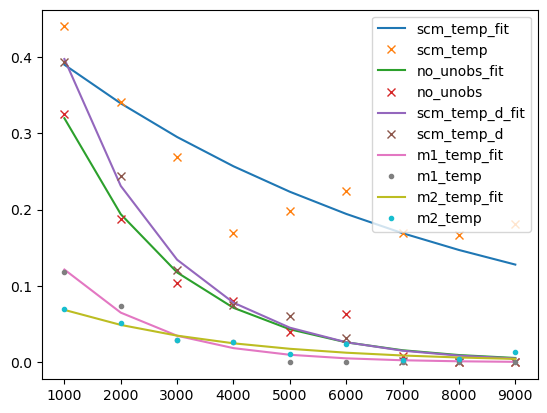

In [8]:
# Fit an exponential decay to the covariance

def exp_decay(x, a, b):
    return a * np.exp(-b * x)

def calc_covariance(series, dist, bins):
    labels = []
    values = []
    counts = []
    mean_temp = np.nanmean(series)

    for b_lower, b_upper in zip(bins[:-1], bins[1:]):
        mask = (dist > b_lower) & (dist <= b_upper)

        diff = (series - mean_temp).reshape(-1, 1)
        diff = np.matmul(diff, diff.T)

        # Calculate the average of the differences
        avg_diff = np.nansum(diff * mask) / mask.sum()

        labels.append((b_lower + b_upper) / 2)
        values.append(avg_diff)
        counts.append(mask.sum())

    return labels, values, counts

# Look at SCM_TEMP, NO_UNOBS, M1_TEMP, M2_TEMP

bins = np.arange(500, 10_000, 1000)

cov_calcs = {}
for label in ['scm_temp', 'no_unobs', 'scm_temp_d']:#, 'm4_temp', 'eve_avg']:
    labels, values, c = calc_covariance(res[label].values, dist, bins)
    values = np.array([0 if v < 0 else v for v in values])
    gt0 = False
    for i, v in enumerate(values):
        if v == 0 :
            gt0 = True
        if gt0:
            values[i] = 0

    popt, pcov = curve_fit(exp_decay, labels, values, p0=[1, 1e-6])
    cov_calcs[label] = [labels, values, exp_decay(np.array(labels), *popt)]
    print(popt)
    plt.plot(labels, exp_decay(np.array(labels), *popt), '-', label=label + '_fit')
    plt.plot(labels, values, 'x', label=label)


for label in ['m1_temp','m2_temp' ]:#, 'm4_temp', 'eve_avg']:
    labels, values, c = calc_covariance(res[label].values, dist, bins)
    print(c)
    # Replace all values < 0 with 
    values = np.array([0 if v < 0 else v for v in values])
    # Make all values 0 once the value is 0
    gt0 = False
    for i, v in enumerate(values):
        if v == 0 :
            gt0 = True
        if gt0:
            values[i] = 0
    popt, pcov = curve_fit(exp_decay, labels, values, p0=[1, 1e-6])
    print(popt)
    # new_bins = calc_new_bins(labels, bins)
    cov_calcs[label] = [labels, values, exp_decay(np.array(labels), *popt)]
    plt.plot(labels, exp_decay(np.array(labels), *popt), '-', label=label + '_fit')
    plt.plot(labels, values, '.', label=label)
    print(values)

bin_counts = c
plt.legend()
plt.show()

We can calculate the significance of individual r-values.

In [9]:
from itertools import product

models = ['m1_temp', 'm2_temp']
truth = ['scm_temp', 'no_unobs', 'scm_temp_d']


# np.sum(cov_calcs['scm_temp_d'][2] * cov_calcs['m4_temp'][2] * np.array(bin_counts))

def r_sigma2(series1, series2, bin_counts):
    denom = len(res[series2])**2 * res[series1].std()**2 * res[series2].std()**2
    return np.sum(cov_calcs[series1][2] * cov_calcs[series2][2] * bin_counts) / denom


def compute_ess(s1, s2, bin_counts):
    rs2 = r_sigma2(s1, s2, bin_counts)
    M = 1 + 1/rs2
    return M, rs2


def calc_pearson_r(s1, s2):
    """Ensure all values are non-nan"""
    # mask = ((~res[s2].isna()) & (~res[s1].isna())).values
    return pearsonr(res[s1][mask].values, res[s2][mask].values)[0]

def calc_f_pdf(r, ess):
    num = (1 - r**2)**(ess/2 - 2)
    den = beta(0.5, ess/2 - 1)
    return num / den


def t_score(r, n ):
    
    return (n - 2)**0.5*r / (1 - r**2)**0.5


for m, t in product(models, truth):
    # Compute effective sample size
    ess, rs2 = compute_ess(m, t, bin_counts)

    # Calculate pearson correlation
    r = calc_pearson_r(m, t)
    # f_m = calc_f_pdf(r, ess)
    # Calculate the t-score then plug that into a T-table to calculate
    # the critical value.
    t_s = t_score(r, ess)

    # Calc critical value
    p = 1 - student_t.cdf(t_s, ess - 2)

    # CI95
    ci_95 = (1 - r**2)**0.5 / (ess - 2)**0.5

    print(f'{m} vs {t}: ESS={ess:.2f}, r={r:.3f}, t_s={t_s:.4f}, p={p:.4f}, CI95={r - 2*ci_95:.4f}, {r + 2*ci_95:.4f}')

m1_temp vs scm_temp: ESS=71.50, r=0.180, t_s=1.5238, p=0.0660, CI95=-0.0562, 0.4158
m1_temp vs no_unobs: ESS=52.41, r=0.262, t_s=1.9241, p=0.0300, CI95=-0.0103, 0.5334
m1_temp vs scm_temp_d: ESS=50.34, r=0.069, t_s=0.4809, p=0.3164, CI95=-0.2180, 0.3560
m2_temp vs scm_temp: ESS=77.24, r=0.385, t_s=3.6213, p=0.0003, CI95=0.1725, 0.5980
m2_temp vs no_unobs: ESS=70.48, r=0.557, t_s=5.5452, p=0.0000, CI95=0.3559, 0.7575
m2_temp vs scm_temp_d: ESS=68.90, r=0.460, t_s=4.2320, p=0.0000, CI95=0.2424, 0.6767


Now, we can compare the values.

In [10]:
def calc_z_score(r_x1x2, r_yx1, r_yx2, ess):
    z_ryx1 = 0.5 * np.log((1 + r_yx1) / (1 - r_yx1))
    z_ryx2 = 0.5 * np.log((1 + r_yx2) / (1 - r_yx2))
    cov = (r_x1x2*(1 - r_yx1**2 - r_yx2**2) - 0.5*(r_yx1*r_yx2)*(1 - r_yx1**2 - r_yx2**2 - r_x1x2**2)) / ((1 - r_yx1**2)*(1- r_yx2**2))

    z = (z_ryx1 - z_ryx2) / (2 - 2*cov)**0.5 * (ess - 2)**0.5

    return z

def calc_corr(s1, s2, s3):
    r1 = calc_pearson_r(s2, s3)
    r2 = calc_pearson_r(s1, s2)
    r3 = calc_pearson_r(s1, s3)

    ess_1, _ = compute_ess(s1, s2, bin_counts)
    ess_2, _ = compute_ess(s1, s3, bin_counts)

    ess = (ess_1 + ess_2) / 2
    # ess = 64
    z = calc_z_score(r1, r2, r3, ess)
    if z < 0:
        p = norm.cdf(z)
    else:
        p = 1 - norm.cdf(z)

    return z, p, ess


comparisons = [
    ['scm_temp', 'm1_temp', 'm2_temp'],
    ['no_unobs', 'm1_temp', 'm2_temp'],
    ['scm_temp_d', 'm1_temp', 'm2_temp'],
    ['m1_temp', 'scm_temp', 'no_unobs'],
    ['m1_temp', 'scm_temp', 'scm_temp_d'],
    ['m2_temp', 'scm_temp', 'no_unobs'],
    ['m2_temp', 'scm_temp', 'scm_temp_d'],
]

for row in comparisons:
    z, p, ess = calc_corr(*row)
    print(f'{row[1]} vs {row[2]} by {row[0]}: z={z:.4f}, p={p:.4f}, ESS={ess:.2f}')

m1_temp vs m2_temp by scm_temp: z=-2.5865, p=0.0048, ESS=74.37
m1_temp vs m2_temp by no_unobs: z=-3.6513, p=0.0001, ESS=61.45
m1_temp vs m2_temp by scm_temp_d: z=-4.4794, p=0.0000, ESS=59.62
scm_temp vs no_unobs by m1_temp: z=-0.8643, p=0.1937, ESS=61.96
scm_temp vs scm_temp_d by m1_temp: z=1.0172, p=0.1545, ESS=60.92
scm_temp vs no_unobs by m2_temp: z=-2.2586, p=0.0120, ESS=73.86
scm_temp vs scm_temp_d by m2_temp: z=-0.8346, p=0.2020, ESS=73.07
